In [24]:
#Generate lists, tuples, linkedLists
#Put into csv file
#include size, number of unique elements, etc
#maybe create a function that determines initial sortedness without sorting

import numpy as np
import csv
from numpy.random import default_rng
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


In [4]:
def generate_array(size, mean=0, std=1, n_unique=10):
    if n_unique > size:
        raise ValueError("Number of unique elements cannot exceed array size.")

    half = n_unique // 2
    if n_unique % 2 == 0:
        unique_vals = np.arange(-half, half)
    else:
        unique_vals = np.arange(-half, half + 1)

    unique_vals = (unique_vals * std) + mean
    unique_vals = unique_vals.astype(np.int64)

    sampled = np.random.choice(unique_vals, size=size, replace=True)

    return sampled

def write_to_csv(array, filepath, mode='a'):
    with open(filepath, mode, newline='') as f:
        writer = csv.writer(f)
        writer.writerow(array)

def generate_data_structure_array(num_points):
    features = np.identity(5, dtype=np.int64)
    for x in range(int(num_points/5 - 1)):
        new_ident = np.identity(5, dtype=np.int64)
        features = np.concatenate((features, new_ident))
    for y in range(num_points%5):
        features = np.vstack((features, [1, 0, 0, 0, 0, 0]))
    np.random.shuffle(features)
    return features

In [5]:
min_size, max_size = 1000, 10000
min_mean, max_mean = 10, 100
min_stddev, max_stddev = .1, 3
min_unique, max_unique = 0.7, 1
num_points = 1000
data_file = "data/data_no_pandas.csv"
features_file = "data/mock_features.csv"

#Clear out CSV Files
with open(data_file, "w") as file:
    file.truncate(0)

with open(features_file, "w") as file:
    file.truncate(0)

rng = np.random.default_rng()
size_features = np.random.randint(min_size, max_size, size=(num_points, 1)) 
data_structure_features = generate_data_structure_array(num_points)

for x in range(num_points):
    size = np.random.randint(min_size, max_size)
    mean = np.random.randint(min_mean, max_mean)
    stddev = np.random.uniform(min_stddev, max_stddev)
    percent_unique = np.random.uniform(0.7, 1)
    num_unique = int(size * percent_unique)

    arr = generate_array(size, mean, stddev, num_unique)
    
    #write_to_csv(arr, data_file)
    features = [size, np.mean(arr), np.std(arr), len(np.unique(arr))]
    features = features + data_structure_features[x].tolist()
    write_to_csv(features, features_file)


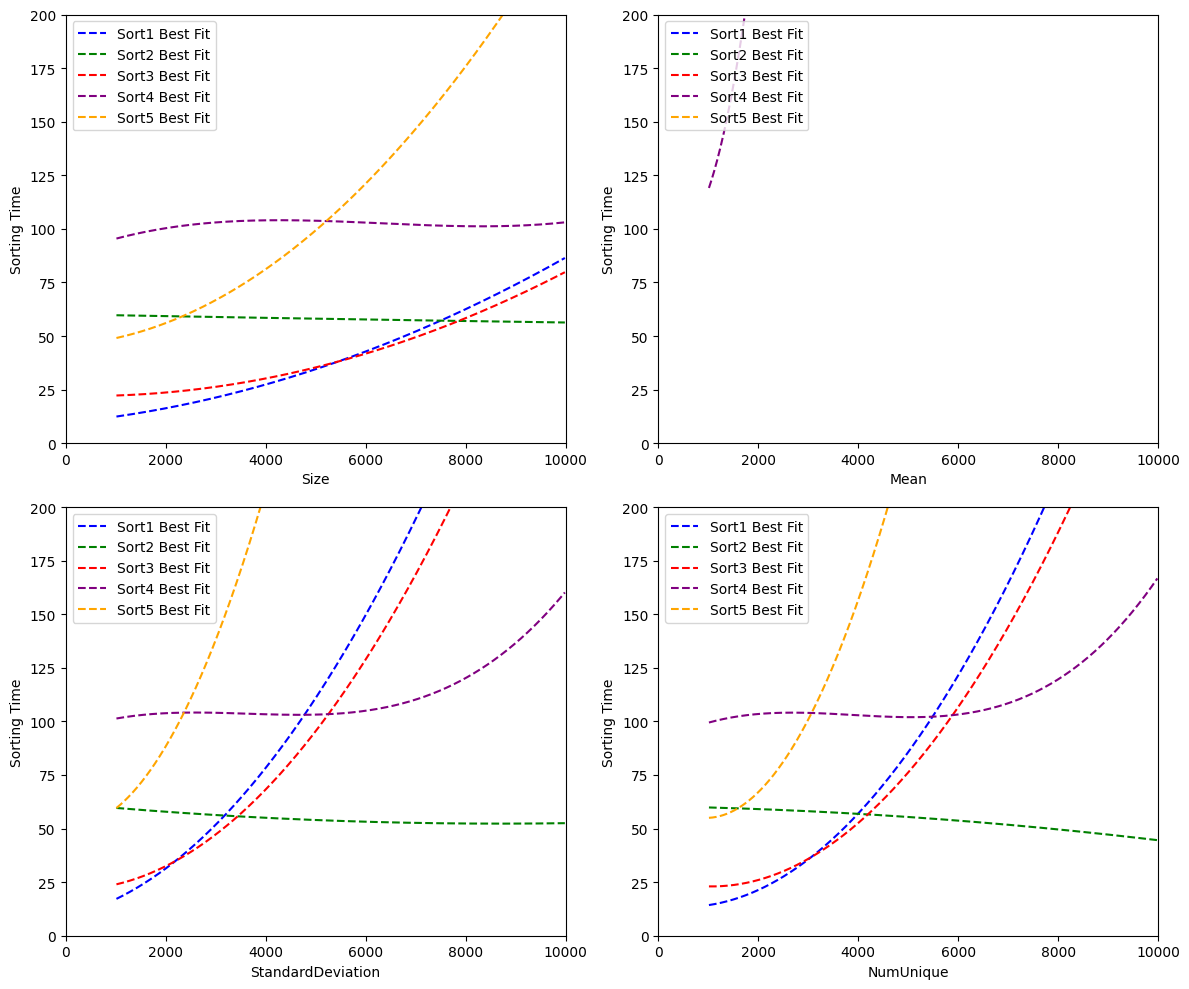

In [ ]:
def generate_seed(row):
    size = row[0]
    mean = row[1]
    stddev = row[2]
    numUnique = row[3]

    if pd.isna(size) or pd.isna(mean) or pd.isna(stddev) or pd.isna(numUnique):
        return None

    seed = (size * 0.5) + (mean * 0.2) + (stddev * 0.15) + (numUnique * 0.15)
    return int(seed)

def generate_random_features(row, noise_scale=10):
    size = row['Size']
    mean = row['Mean']
    stddev = row['StandardDeviation']
    numUnique = row['NumUnique']

    base_sort_time = (size / 1000) + random.uniform(-5, 5)

    y_intercept1 = random.uniform(0, 20)
    y_intercept2 = random.uniform(50, 70)
    y_intercept3 = random.uniform(10, 30)
    y_intercept4 = random.uniform(50, 150)
    y_intercept5 = random.uniform(20, 80)

    noise = lambda: random.uniform(-noise_scale, noise_scale)

    # Sort 1: Prefers small size, high stddev. Mixed linear and quadratic relationships
    sort1 = y_intercept1
    sort1 += -0.4 * (size / 1000)
    sort1 += 0.6 * (stddev / 100)
    sort1 += -0.02 * ((size / 1000) ** 2)
    sort1 += 0.03 * ((stddev / 100) ** 2)
    sort1 += 0.1 * (mean / 100)  # small effect
    sort1 += noise()

    # Sort 2: Linear and cubic; prefers large size, low stddev, penalized for high mean
    sort2 = y_intercept2
    sort2 += 0.3 * (size / 1000)
    sort2 += -0.2 * (stddev / 100)
    sort2 += -0.05 * ((mean / 100) ** 3)
    sort2 += 0.04 * ((numUnique / 1000) ** 2)
    sort2 += noise()

    # Sort 3: Exponential-ish on size, quadratic on stddev, slightly prefers high mean
    sort3 = y_intercept3
    sort3 += 0.5 * np.log1p(size) / 10
    sort3 += 0.03 * ((stddev / 100) ** 2)
    sort3 += 0.1 * (mean / 100)
    sort3 += -0.02 * ((numUnique / 1000) ** 2)
    sort3 += noise()

    # Sort 4: Mixed (quadratic for numUnique, cubic for mean), prefers moderate values
    sort4 = y_intercept4
    sort4 += -0.3 * ((numUnique / 1000) - 2) ** 2  # valley around 2000
    sort4 += 0.01 * ((mean / 100) ** 3)
    sort4 += 0.1 * (stddev / 100)
    sort4 += -0.01 * (size / 1000)
    sort4 += noise()

    # Sort 5: Penalized for extremes, mixed linear/quadratic/cubic
    sort5 = y_intercept5
    sort5 += 0.08 * (mean / 100)                             
    sort5 += 0.1 * ((mean / 100 - 1.5) ** 2)                  
    sort5 += 0.1 * ((stddev / 100) ** 2)                 
    sort5 += 0.05 * (size / 1000)                                
    sort5 += -0.2 * ((numUnique / 1000 - 2) ** 2)               
    sort5 += noise()

    return [sort1, sort2, sort3, sort4, sort5]

# Polynomial fitting function (for varying degrees)
def fit_polynomial(x, y, degree):
    # Fit polynomial of given degree
    coeffs = np.polyfit(x, y, degree)
    poly = np.poly1d(coeffs)
    return poly

def process_file(input_path, output_path):
    df = pd.read_csv(input_path)
    df.columns = df.columns.str.strip()
    
    output_rows = []
    
    size_data = df['Size']
    mean_data = df['Mean']
    stddev_data = df['StandardDeviation']
    numUnique_data = df['NumUnique']
    
    sort1_data = []
    sort2_data = []
    sort3_data = []
    sort4_data = []
    sort5_data = []
    
    for index, row in df.iterrows():
        rand_vals = generate_random_features(row)
        output_row = list(row[:4]) + rand_vals
        output_rows.append(output_row)
        
        sort1_data.append(rand_vals[0])
        sort2_data.append(rand_vals[1])
        sort3_data.append(rand_vals[2])
        sort4_data.append(rand_vals[3])
        sort5_data.append(rand_vals[4])
    
    final_df = pd.DataFrame(output_rows, columns=["Size", "Mean", "StandardDeviation", "NumUnique", "Sort1", "Sort2", "Sort3", "Sort4", "Sort5"])
    final_df.to_csv(output_path, index=False)
    
    fig, axs = plt.subplots(2, 2, figsize=(12, 10))
    
    # Size vs Sort Time
    """ axs[0, 0].scatter(size_data, sort1_data, label='Sort1', color='blue', alpha=0.5)
    axs[0, 0].scatter(size_data, sort2_data, label='Sort2', color='green', alpha=0.5)
    axs[0, 0].scatter(size_data, sort3_data, label='Sort3', color='red', alpha=0.5)
    axs[0, 0].scatter(size_data, sort4_data, label='Sort4', color='purple', alpha=0.5)
    axs[0, 0].scatter(size_data, sort5_data, label='Sort5', color='orange', alpha=0.5) """
    
    # Fit and plot best-fit lines
    poly1 = fit_polynomial(size_data, sort1_data, 2)  
    poly2 = fit_polynomial(size_data, sort2_data, 2) 
    poly3 = fit_polynomial(size_data, sort3_data, 2) 
    poly4 = fit_polynomial(size_data, sort4_data, 3) 
    poly5 = fit_polynomial(size_data, sort5_data, 2)  
    
    
    x_vals = np.linspace(min(size_data), max(size_data), 1000)
    
    # Plot the best-fit lines
    axs[0, 0].plot(x_vals, poly1(x_vals), color='blue', linestyle='--', label='Sort1 Best Fit')
    axs[0, 0].plot(x_vals, poly2(x_vals), color='green', linestyle='--', label='Sort2 Best Fit')
    axs[0, 0].plot(x_vals, poly3(x_vals), color='red', linestyle='--', label='Sort3 Best Fit')
    axs[0, 0].plot(x_vals, poly4(x_vals), color='purple', linestyle='--', label='Sort4 Best Fit')
    axs[0, 0].plot(x_vals, poly5(x_vals), color='orange', linestyle='--', label='Sort5 Best Fit')
    
    # Mean vs Sort Time
    """ axs[0, 1].scatter(mean_data, sort1_data, label='Sort1', color='blue', alpha=0.5)
    axs[0, 1].scatter(mean_data, sort2_data, label='Sort2', color='green', alpha=0.5)
    axs[0, 1].scatter(mean_data, sort3_data, label='Sort3', color='red', alpha=0.5)
    axs[0, 1].scatter(mean_data, sort4_data, label='Sort4', color='purple', alpha=0.5)
    axs[0, 1].scatter(mean_data, sort5_data, label='Sort5', color='orange', alpha=0.5) """
    
    poly1 = fit_polynomial(mean_data, sort1_data, 2)
    poly2 = fit_polynomial(mean_data, sort2_data, 2)
    poly3 = fit_polynomial(mean_data, sort3_data, 2)
    poly4 = fit_polynomial(mean_data, sort4_data, 3)
    poly5 = fit_polynomial(mean_data, sort5_data, 2)
    
    axs[0, 1].plot(x_vals, poly1(x_vals), color='blue', linestyle='--', label='Sort1 Best Fit')
    axs[0, 1].plot(x_vals, poly2(x_vals), color='green', linestyle='--', label='Sort2 Best Fit')
    axs[0, 1].plot(x_vals, poly3(x_vals), color='red', linestyle='--', label='Sort3 Best Fit')
    axs[0, 1].plot(x_vals, poly4(x_vals), color='purple', linestyle='--', label='Sort4 Best Fit')
    axs[0, 1].plot(x_vals, poly5(x_vals), color='orange', linestyle='--', label='Sort5 Best Fit')
    
    # Stddev vs Sort Time
    """ axs[1, 0].scatter(stddev_data, sort1_data, label='Sort1', color='blue', alpha=0.5)
    axs[1, 0].scatter(stddev_data, sort2_data, label='Sort2', color='green', alpha=0.5)
    axs[1, 0].scatter(stddev_data, sort3_data, label='Sort3', color='red', alpha=0.5)
    axs[1, 0].scatter(stddev_data, sort4_data, label='Sort4', color='purple', alpha=0.5)
    axs[1, 0].scatter(stddev_data, sort5_data, label='Sort5', color='orange', alpha=0.5) """
    
    poly1 = fit_polynomial(stddev_data, sort1_data, 2)
    poly2 = fit_polynomial(stddev_data, sort2_data, 2)
    poly3 = fit_polynomial(stddev_data, sort3_data, 2)
    poly4 = fit_polynomial(stddev_data, sort4_data, 3)
    poly5 = fit_polynomial(stddev_data, sort5_data, 2)
    
    axs[1, 0].plot(x_vals, poly1(x_vals), color='blue', linestyle='--', label='Sort1 Best Fit')
    axs[1, 0].plot(x_vals, poly2(x_vals), color='green', linestyle='--', label='Sort2 Best Fit')
    axs[1, 0].plot(x_vals, poly3(x_vals), color='red', linestyle='--', label='Sort3 Best Fit')
    axs[1, 0].plot(x_vals, poly4(x_vals), color='purple', linestyle='--', label='Sort4 Best Fit')
    axs[1, 0].plot(x_vals, poly5(x_vals), color='orange', linestyle='--', label='Sort5 Best Fit')
    
    # NumUnique vs Sort Time
    """ axs[1, 1].scatter(numUnique_data, sort1_data, label='Sort1', color='blue', alpha=0.5)
    axs[1, 1].scatter(numUnique_data, sort2_data, label='Sort2', color='green', alpha=0.5)
    axs[1, 1].scatter(numUnique_data, sort3_data, label='Sort3', color='red', alpha=0.5)
    axs[1, 1].scatter(numUnique_data, sort4_data, label='Sort4', color='purple', alpha=0.5)
    axs[1, 1].scatter(numUnique_data, sort5_data, label='Sort5', color='orange', alpha=0.5) """
    
    poly1 = fit_polynomial(numUnique_data, sort1_data, 2)
    poly2 = fit_polynomial(numUnique_data, sort2_data, 2)
    poly3 = fit_polynomial(numUnique_data, sort3_data, 2)
    poly4 = fit_polynomial(numUnique_data, sort4_data, 3)
    poly5 = fit_polynomial(numUnique_data, sort5_data, 2)
    
    axs[1, 1].plot(x_vals, poly1(x_vals), color='blue', linestyle='--', label='Sort1 Best Fit')
    axs[1, 1].plot(x_vals, poly2(x_vals), color='green', linestyle='--', label='Sort2 Best Fit')
    axs[1, 1].plot(x_vals, poly3(x_vals), color='red', linestyle='--', label='Sort3 Best Fit')
    axs[1, 1].plot(x_vals, poly4(x_vals), color='purple', linestyle='--', label='Sort4 Best Fit')
    axs[1, 1].plot(x_vals, poly5(x_vals), color='orange', linestyle='--', label='Sort5 Best Fit')
    
    feature_names = ['Size', 'Mean', 'StandardDeviation', 'NumUnique']

    for i, ax in enumerate(axs.flat):
        feature = feature_names[i]
        ax.set_xlabel(feature) 
        ax.set_ylabel('Sorting Time')
        ax.set_ylim(0, 200)
        ax.set_xlim(0, 10000)
        ax.legend(loc='upper left')
    

    plt.tight_layout()
    plt.show()

process_file("data/mock_timings.csv", "data/mock_timings.csv")

Epoch 1/150


c:\Users\aborc\miniconda3\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - accuracy: 0.2820 - loss: 1.6119 - val_accuracy: 0.5950 - val_loss: 1.3842
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.5310 - loss: 1.3710 - val_accuracy: 0.6200 - val_loss: 1.1941
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6148 - loss: 1.1494 - val_accuracy: 0.6350 - val_loss: 0.9711
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6384 - loss: 0.9680 - val_accuracy: 0.6450 - val_loss: 0.8469
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - accuracy: 0.6139 - loss: 0.8787 - val_accuracy: 0.6550 - val_loss: 0.7736
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.6454 - loss: 0.8177 - val_accuracy: 0.6400 - val_loss: 0.7461
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - accuracy: 0.6718 - loss: 0.7767 - val_accuracy: 0.6700 - val_loss: 0.7277
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.6484 - loss: 0.7536 - val_accuracy: 0.6850 - val_loss

c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\aborc\miniconda3\Lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


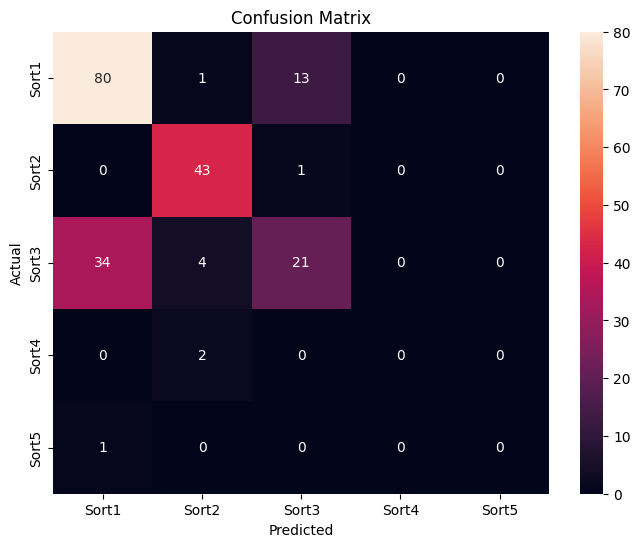

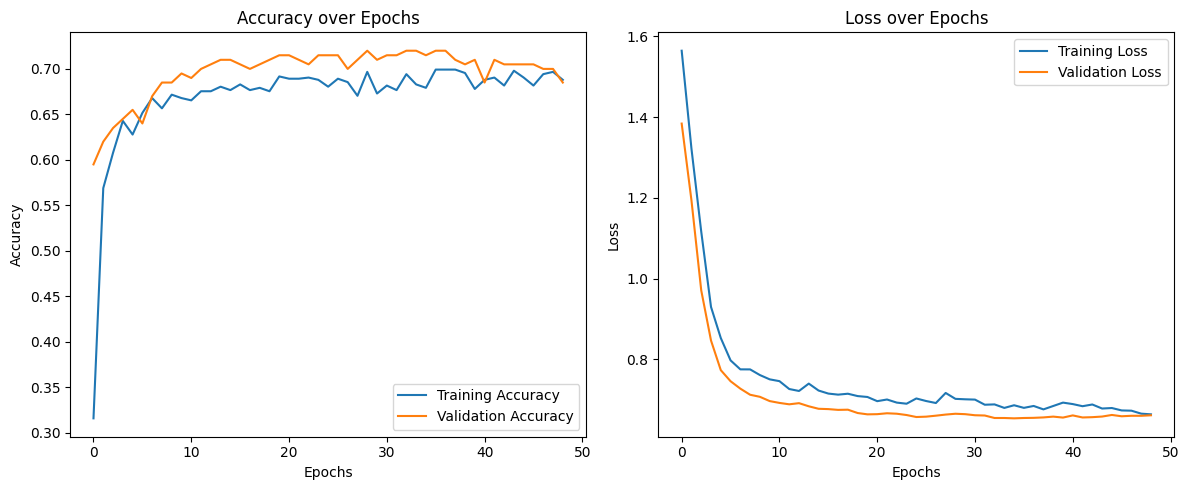

In [120]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.python import keras
from keras import Sequential
from keras.api.layers import Dense, Dropout
from keras.api.optimizers import Adam
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
df = pd.read_csv('./data/mock_timings.csv')

# Define features and sort time columns
features = ['Size', 'Mean', 'StandardDeviation', 'NumUnique']
sorts = ['Sort1', 'Sort2', 'Sort3', 'Sort4', 'Sort5']

# Create 'BestSort' column
df['BestSort'] = df[sorts].idxmin(axis=1)

# Define X and y
X = df[features]
y = df['BestSort']

# Encode the target labels
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42)

# Scale the features - VERY IMPORTANT for neural networks
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)  # Apply the same scaling to the test set

# Build the neural network model - Increased complexity, dropout, and adjusted learning rate.
model = Sequential([
    Dense(128, input_dim=X_train_scaled.shape[1], activation='relu'),
    Dropout(0.3),  # Dropout for regularization
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(5, activation='softmax')
])

# Compile the model with an adjusted learning rate
optimizer = Adam(learning_rate=0.001)  # Lower learning rate
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model with early stopping to prevent overfitting
#  and a larger number of epochs
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=20, restore_best_weights=True) # Increased patience
history = model.fit(X_train_scaled, y_train, epochs=150, batch_size=64, validation_data=(X_test_scaled, y_test), callbacks=[early_stopping]) # Increased epochs, larger batch size

# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test_scaled, y_test)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

# Predict on the test set
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred_classes, target_names=encoder.classes_))

# Confusion matrix
confusion = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))  # Added figure size for better visualization
sns.heatmap(confusion, annot=True, fmt='d', xticklabels=encoder.classes_, yticklabels=encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Plot the training history (accuracy and loss)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

